* Linear Regression <br>
   * Most basic form of ML <br>
   * used to predict numeric values <br>
   * most useful when you have data points that correlate in linear fashion <br>
* line of best fit refers to a line through a scatter plot of data points that best expresses the relationship between points
* linear approach to modelling a relationship between a target (dependent) variable and one or more explanatory variables (independent) variables
* Equation of a line y = mx + b <br> 
    m = slope of line (rise vs run) <br>
    b = y-intercept <br>
* close to as many data points as possible with even split of points

In [1]:
!pip install -q sklearn

* Numpy
    * used for vector and matrix operations.
    * Inner product, outer product, dot product, cross product
    * matrix addition/substraction/division/multiplication
    * Elementwise operations and broadcast
* Pandas
    * data analytics tool
    * panel data
    * indexing and selecting tabular data
* matplotlib
    * visualization

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

* Data
    * Load titanic dataset into pandas dataframe
    * exploring, cleaning and selecting appropriate data
* Need of seperate training and test dataset to avoid overfitting and remove any bias
* Training data is the data that we feed to the model so that it can develop and learn
* Test data is the data we need to evaluate the model and see how well it is performing
    * point of building a model is that it should accurately predict outcome on unseen data
* Further cross validation dataset is needed for tuning of hyper-parameters

In [25]:
# training data
dftrain = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
# test data
dfeval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")

In [26]:
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [27]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [28]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 627 non-null    object 
 1   age                 627 non-null    float64
 2   n_siblings_spouses  627 non-null    int64  
 3   parch               627 non-null    int64  
 4   fare                627 non-null    float64
 5   class               627 non-null    object 
 6   deck                627 non-null    object 
 7   embark_town         627 non-null    object 
 8   alone               627 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 44.2+ KB


In [29]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [30]:
dftrain.shape

(627, 9)

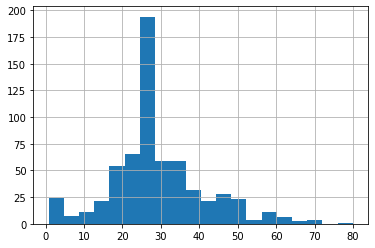

In [31]:
dftrain.age.hist(bins=20)

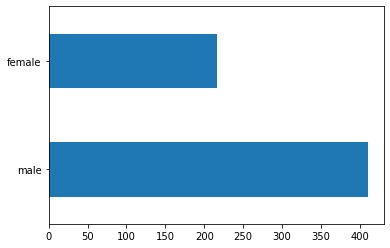

In [32]:
dftrain.sex.value_counts().plot(kind="barh")

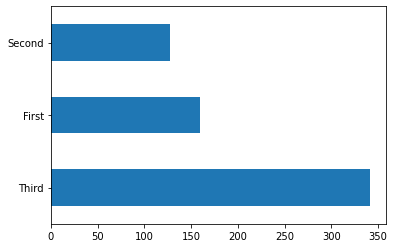

In [33]:
dftrain['class'].value_counts().plot(kind="barh")

Text(0.5, 0, '% survive')

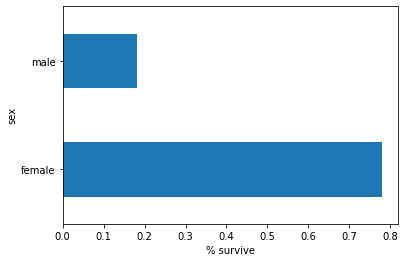

In [34]:
pd.concat([dftrain,y_train], axis=1).groupby('sex').survived.mean().plot(kind="barh").set_xlabel("% survive")

* Feature Columns
    * Categorical - anything that is not numeric, distinct text categories
    * Numeric - continuous numerical data
    * need to convert categorical data into numeric data before building any models
    * Achieved by encoding each category with an integer

In [36]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

#### The Training Process
* How input data is fed into the model
    * Small sized datasets can be fed directly
    * For big datasets, size of RAM is a major constraint
    * Feeding just 1 datapoint slows down the process
    * Hence data is divided into smaller batches of (typically of size 32,64 etc)
* <b>Epoch</b> is simply one stream of our entire dataset
    * Number of epochs is the number of times our model will see the entire dataset
    * By seeing the data multiple times, the model will better determine how to estimate it
    * Overfitting is major concern with higher number of epochs
    * Start with less number of epoch and evaluate with the test dataset
* Input Function
    * efficient as we need to feed our data in batches and for multiple times (for epochs)
    * simply defines how our dataset will be converted to batches for each epoch

In [37]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

#### Creating the model

In [39]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmphzyt_njz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#### Training the model

In [40]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.7765151


#### Predict using the model

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphzyt_njz/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


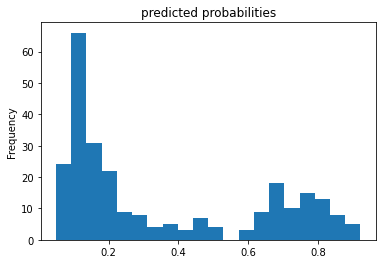

In [50]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [55]:
probs[2]

0.7558669447898865

In [60]:
pred_dicts[2]['probabilities']

array([0.24413306, 0.75586694], dtype=float32)

## Classification
* Regression was used to predict numeric value of outcome
* Classification is used to seperate data points into classes of different labels

In [62]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import pandas as pd

In [63]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

In [64]:
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [65]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [66]:
train_y = train.pop('Species')
test_y = test.pop('Species')
train.head() # the species column is now gone

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


#### Input Function

In [70]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

#### Feature Columns

In [71]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


#### Build the model
* Variety of different estimators/models
* DNNClassifier
* LinearClassifier

In [72]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_1jmfm9h', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#### Train the model

In [74]:
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# We include a lambda to avoid creating an inner function previously

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_1jmfm9h/model.ckpt-5000
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmp_1jmfm9h/model.ckpt.
INFO:tensorflow:loss = 0.47265187, step = 5000
I

#### Evaluate the model on testset

In [75]:
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-17T06:50:24Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_1jmfm9h/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.37254s
INFO:tensorflow:Finished evaluation at 2020-08-17-06:50:24
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.93333334, aver

#### Predictions

In [76]:
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
  valid = True
  while valid: 
    val = input(feature + ": ")
    if not val.isdigit(): valid = False

  predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
        SPECIES[class_id], 100 * probability))

Please type numeric values as prompted.
SepalLength: 23
SepalLength: 12
SepalLength: 12
SepalLength: 3
SepalLength: 4
SepalLength: 2
SepalLength: 0.5
SepalWidth: 2
SepalWidth: 0.4
PetalLength: 0.5
PetalWidth: 0.3
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_1jmfm9h/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "Setosa" (39.9%)


In [77]:
# Here is some example input and expected classes you can try above
expected = ['Setosa', 'Versicolor', 'Virginica']
predict_x = {
    'SepalLength': [5.1, 5.9, 6.9],
    'SepalWidth': [3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.2, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1],
}

## Clustering

* Unsupervised learning
* Lack of labelled data
* Involves grouping of data points into clusters
* Data points which are in same group should have similar properties and/or features
* Data points in different groups should have highly dissimilar properties and/or features

#### Basic algorithm for KMeans

1. Randomly pick K points to place K centroid
2. Assign all data points to the closest entroid based on distance (Eucledian)
3. Move each centroid to average of all the data points assigned to it
4. Reassign every data point to it's closest centroid
5. Repeat steps 3-4 until convergence (no/less movement of centroids)

#### Hidden Markov Models

* finite set of states, each of which is associated with a (generally multi-dimensional) probability distribution
* Transition among the states are governed by a set a probabilities called the transitional probabilities
* A hidden Markov model works with probabilities to predict future events or states
* Data - we are only interested with probability distributions that have to do with states
* States: finite set, hidden i.e. we do not directly  observe them
* Observations: Each state has a particular outcome or observation associated with it
* Transitions: Each state will have a probability defining the likelihood of transitioning to a different state

In [78]:
!pip install tensorflow_probability==0.8.0rc0 --user --upgrade

     |████████████████████████████████| 2.5 MB 1.7 MB/s eta 0:00:01
ERROR: spyder 4.0.1 requires pyqt5<5.13; python_version >= "3", which is not installed.
ERROR: spyder 4.0.1 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.


In [80]:
import tensorflow_probability as tfp  # We are using a different module from tensorflow this time
import tensorflow as tf

In [88]:
tfd = tfp.distributions  # making a shortcut for later on
initial_distribution = tfd.Categorical(probs=[0.8, 0.2])  # Refer to point 2 above
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3],
                                                 [0.2, 0.8]])  # refer to points 3 and 4 above
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])  # refer to point 5 above

# the loc argument represents the mean and the scale is the standard devitation

In [89]:
model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

In [90]:
mean = model.mean()

# due to the way TensorFlow works on a lower level we need to evaluate part of the graph
# from within a session to see the value of this tensor

# in the new version of tensorflow we need to use tf.compat.v1.Session() rather than just tf.Session()
with tf.compat.v1.Session() as sess:  
  print(mean.numpy())

[2.9999998 5.9999995 7.4999995 8.25      8.625001  8.812501  8.90625  ]
